# Colors ↔ SBM features continuum

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
import pandas as pd

## Synthetic data

In [2]:
loss_parts = ['adj', 'feat', 'total loss', 'reg', 'kl']
synthetic_id_vars = ['fsbm_p_in', 'fsbm_p_out', 'correlation', 'spill', 'dimξ', 'sample']

synthetic = pd.read_csv('../../data/behaviour/sbmfeatures/'
                        'nnodes=1000-sharedl1=false-decadjdeep=true-'
                        'model=ov710d19-f_sbm_p_in=0.25:0.15:0.99-+f_sbm_p_out=0.010:-0.002:0.000'
                        '-correlation=0:0.2:1-spill=-9:9-dimxi=10:2:20-nsamples=10.csv.gz',
                        compression='gzip')

In [3]:
p_ins = sorted(np.unique(synthetic.fsbm_p_in), reverse=True)
p_outs = []
for p_in in p_ins:
    assert len(set(synthetic.fsbm_p_out[synthetic.fsbm_p_in == p_in])) == 1
    p_outs.append(synthetic.fsbm_p_out[synthetic.fsbm_p_in == p_in].iloc[0])

In [4]:
def reduce_best_totalloss(df, id_vars, val_vars):
    best_total_wide = df\
        .groupby(id_vars)\
        .apply(lambda x: x.loc[x['total loss'].idxmin()])\
        .reset_index(drop=True)
    best_total_wide = best_total_wide[id_vars + val_vars]
    return pd.melt(best_total_wide,
                   id_vars=id_vars,
                   var_name='loss', value_name='best_total')

In [5]:
synthetic_best = reduce_best_totalloss(synthetic, synthetic_id_vars, loss_parts)

In [6]:
def relov(df, id_vars, val_vars):
    maxdimξ = df.dimξ.max()
    rel = pd.pivot_table(df, index=id_vars, columns='loss').reset_index()
    rel.columns = id_vars + list(filter(lambda s: len(s) > 0, rel.columns.droplevel()))
    rel[val_vars] = rel\
        .groupby(['fsbm_p_in', 'fsbm_p_out', 'spill', 'correlation'])\
        .apply(lambda x: x / x[x.dimξ == maxdimξ].mean())[val_vars]
    rel_long = pd.melt(rel,
                       id_vars=id_vars,
                       var_name='loss', value_name='best_total')
    return rel_long

In [7]:
synthetic_best_relov = relov(synthetic_best, synthetic_id_vars, loss_parts)

/home/slerique/anaconda3/envs/base36-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


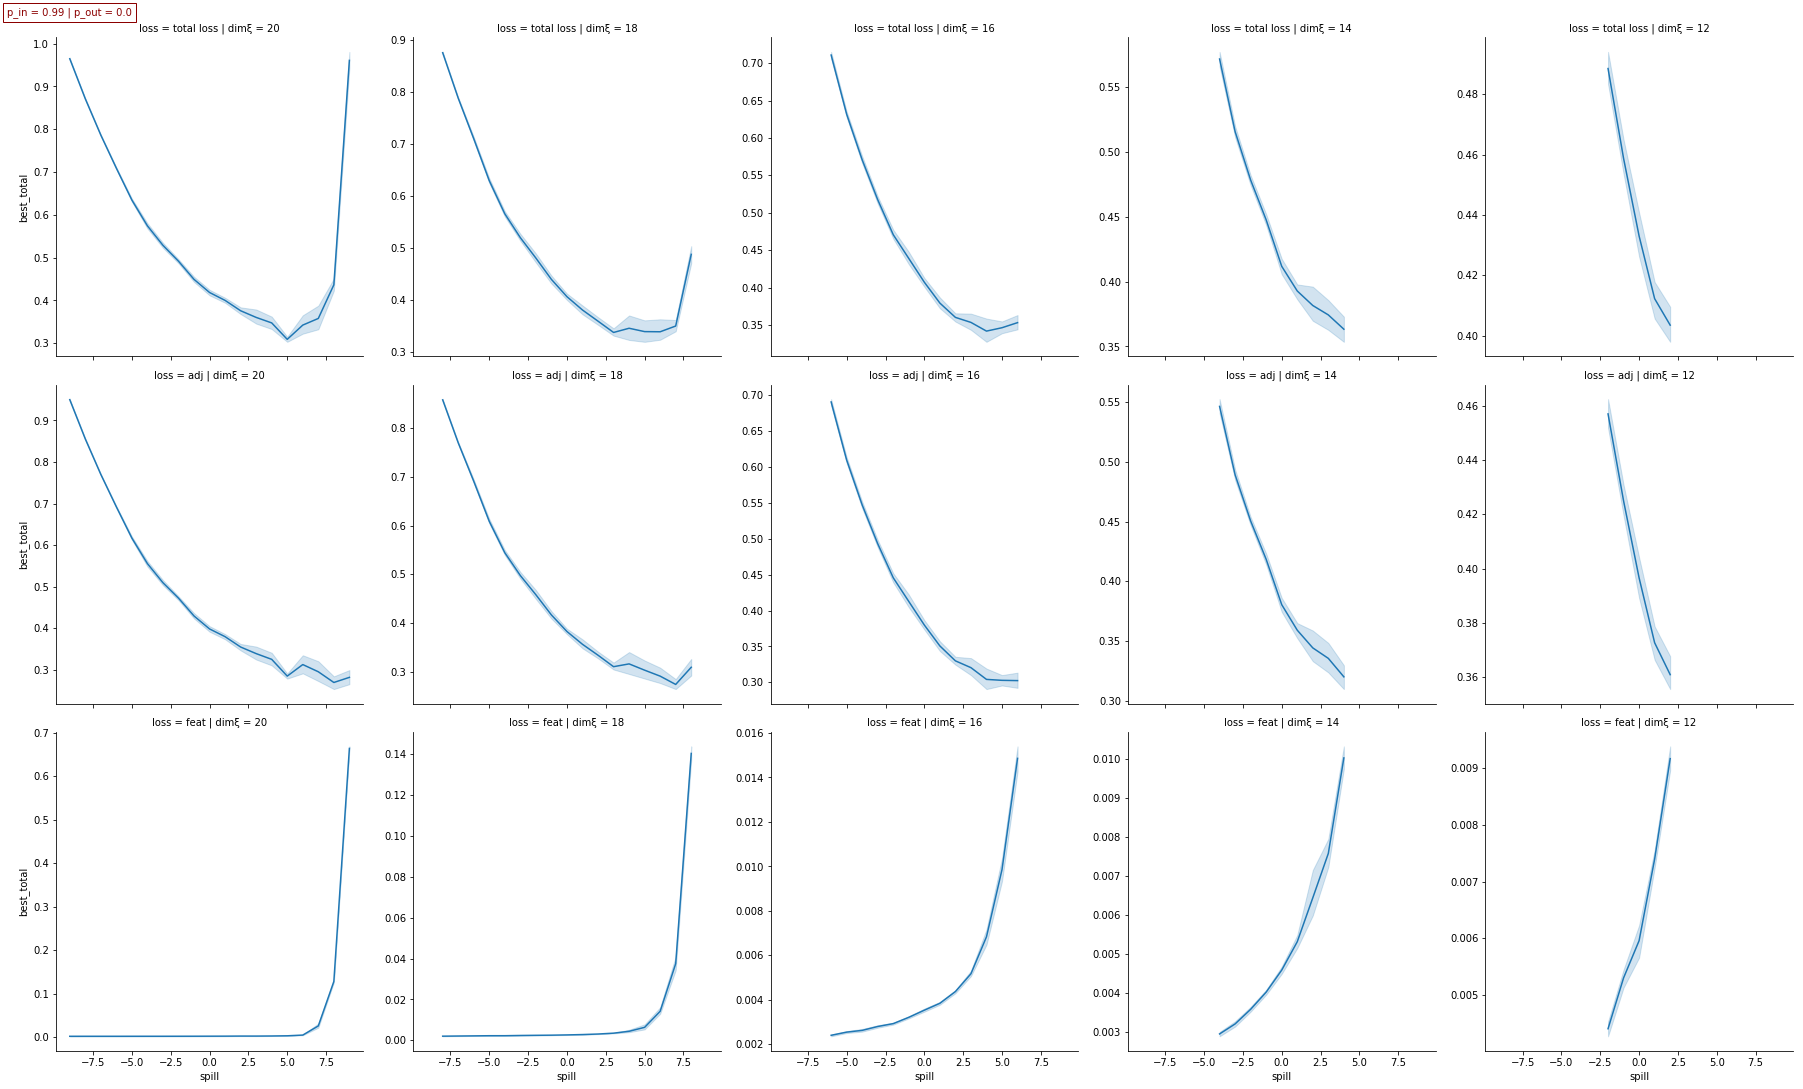

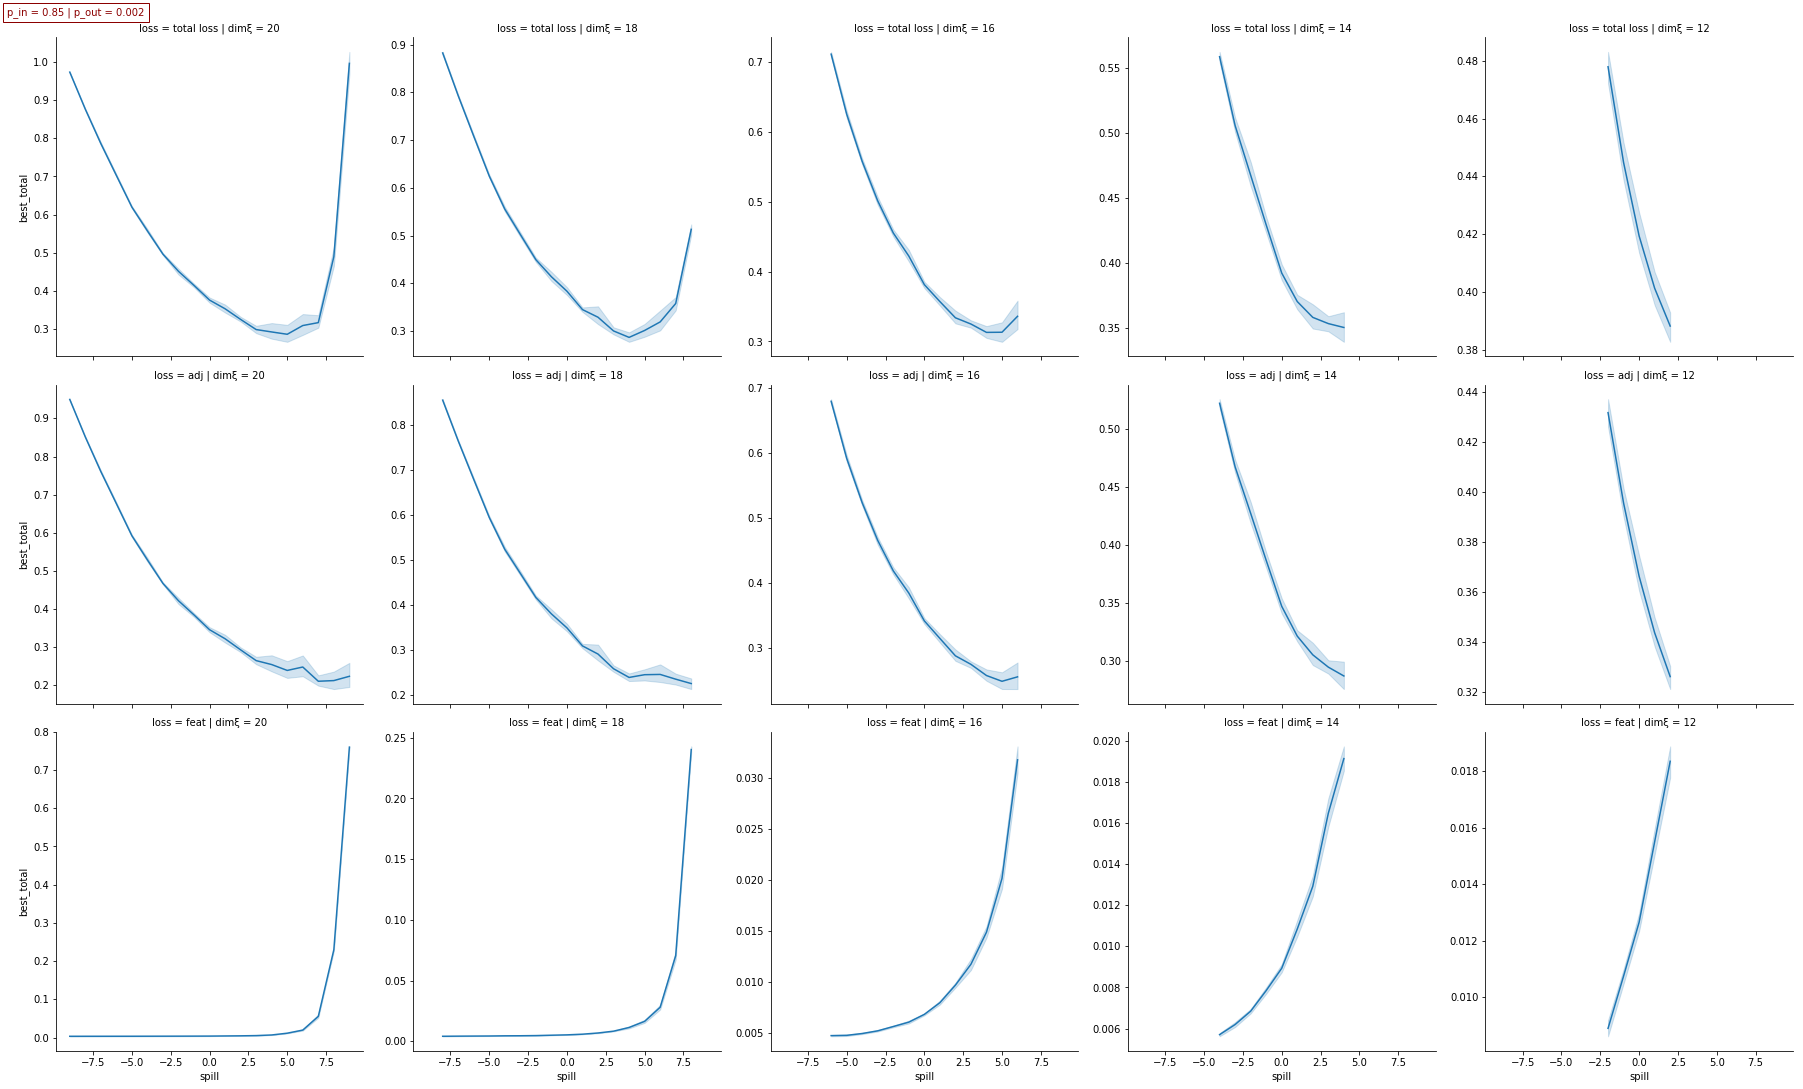

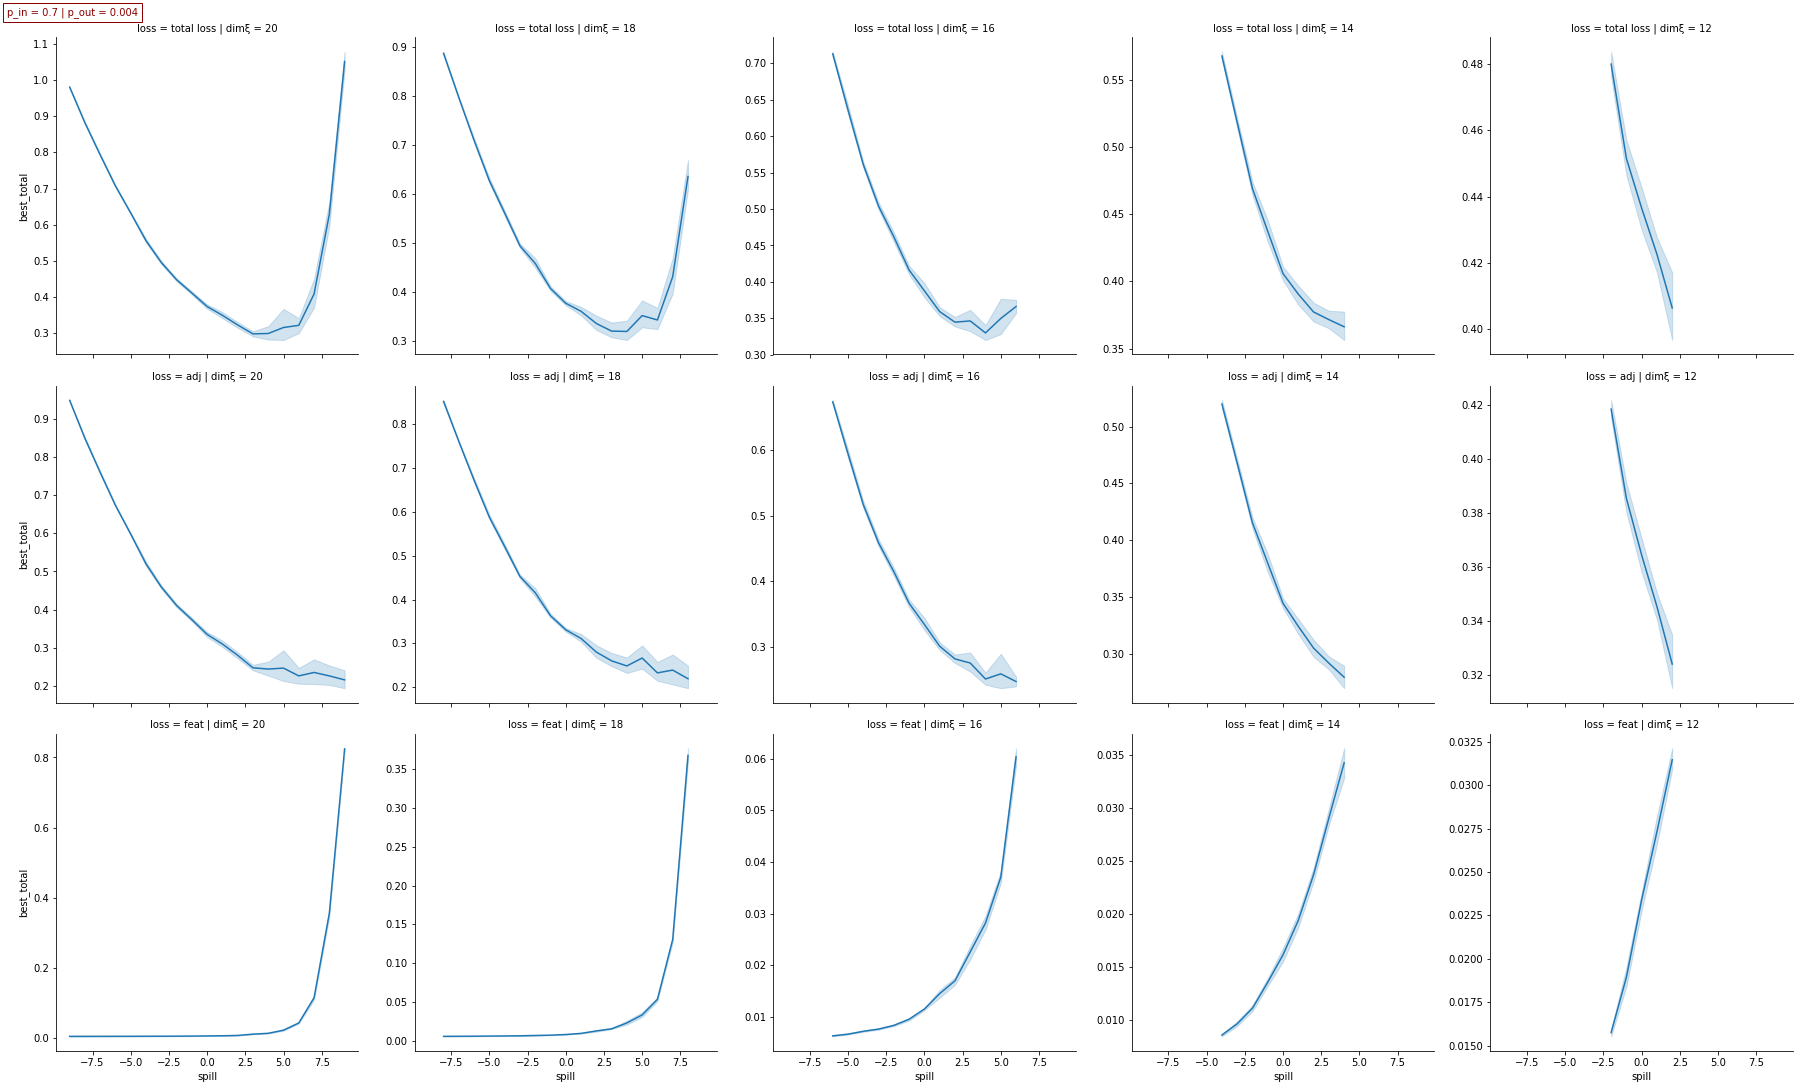

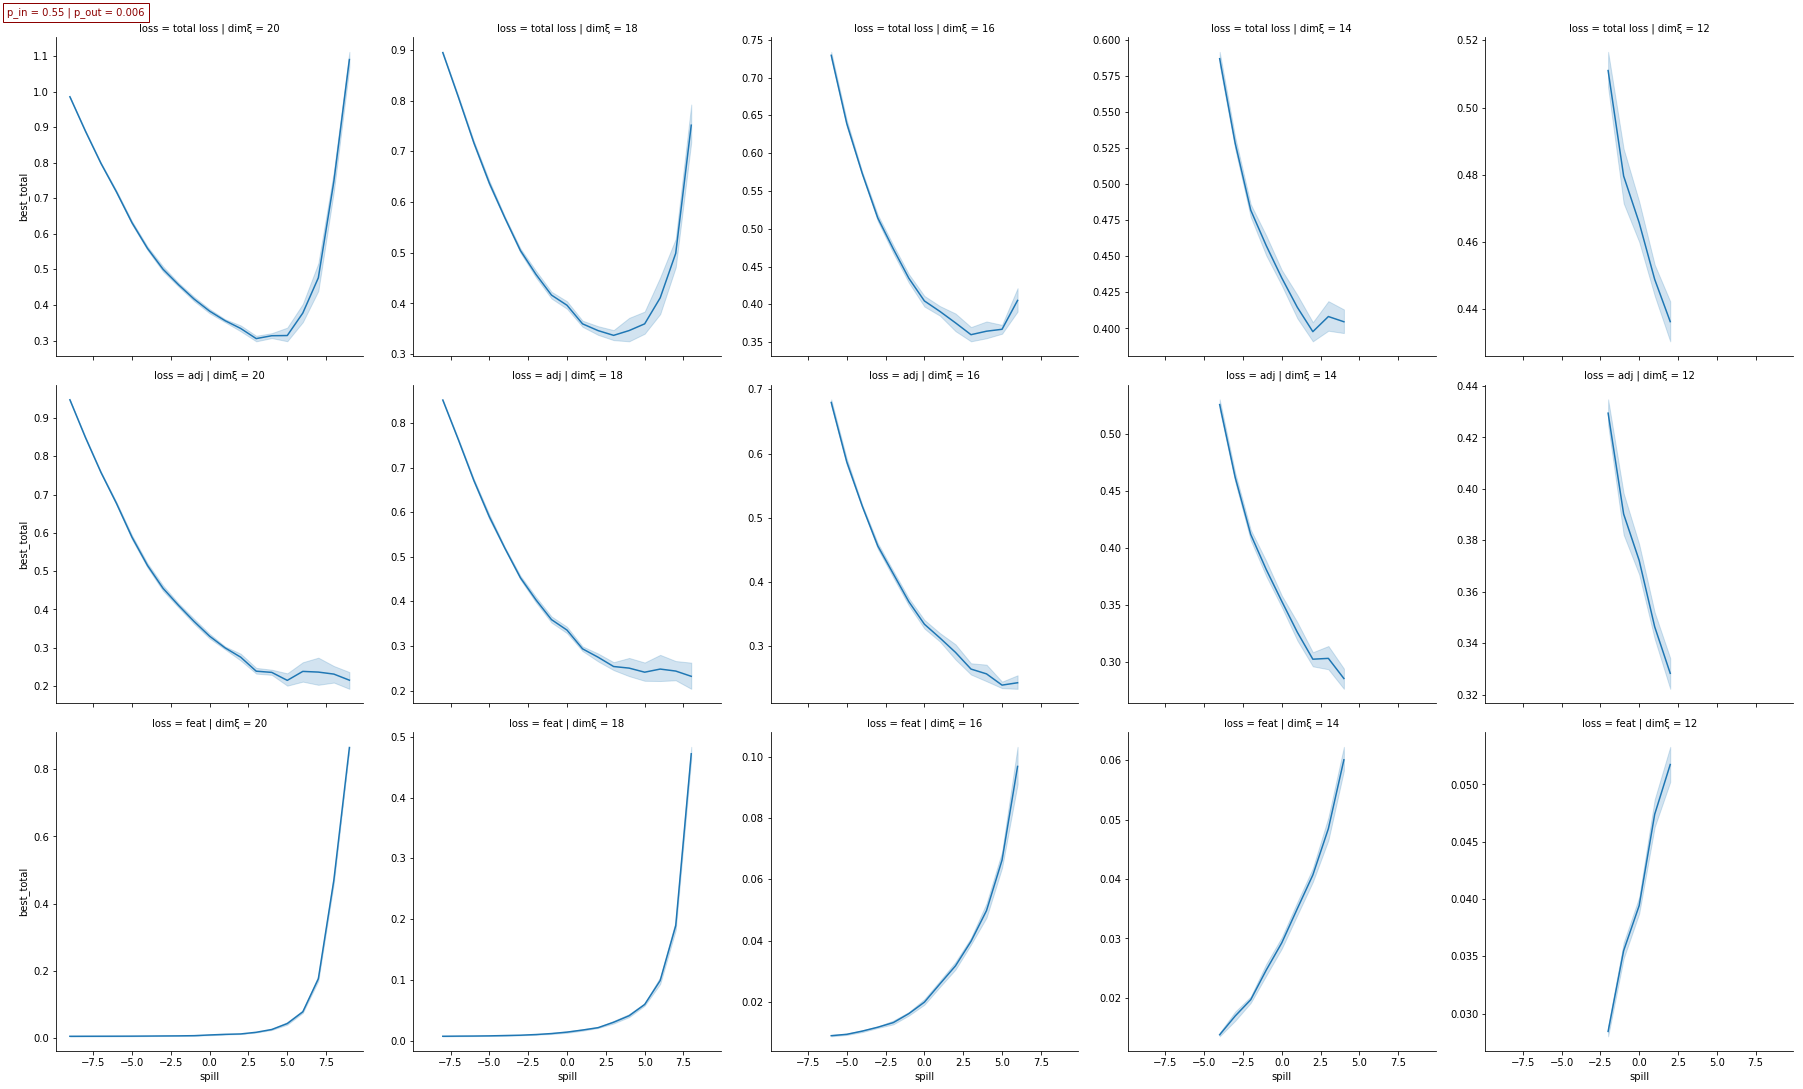

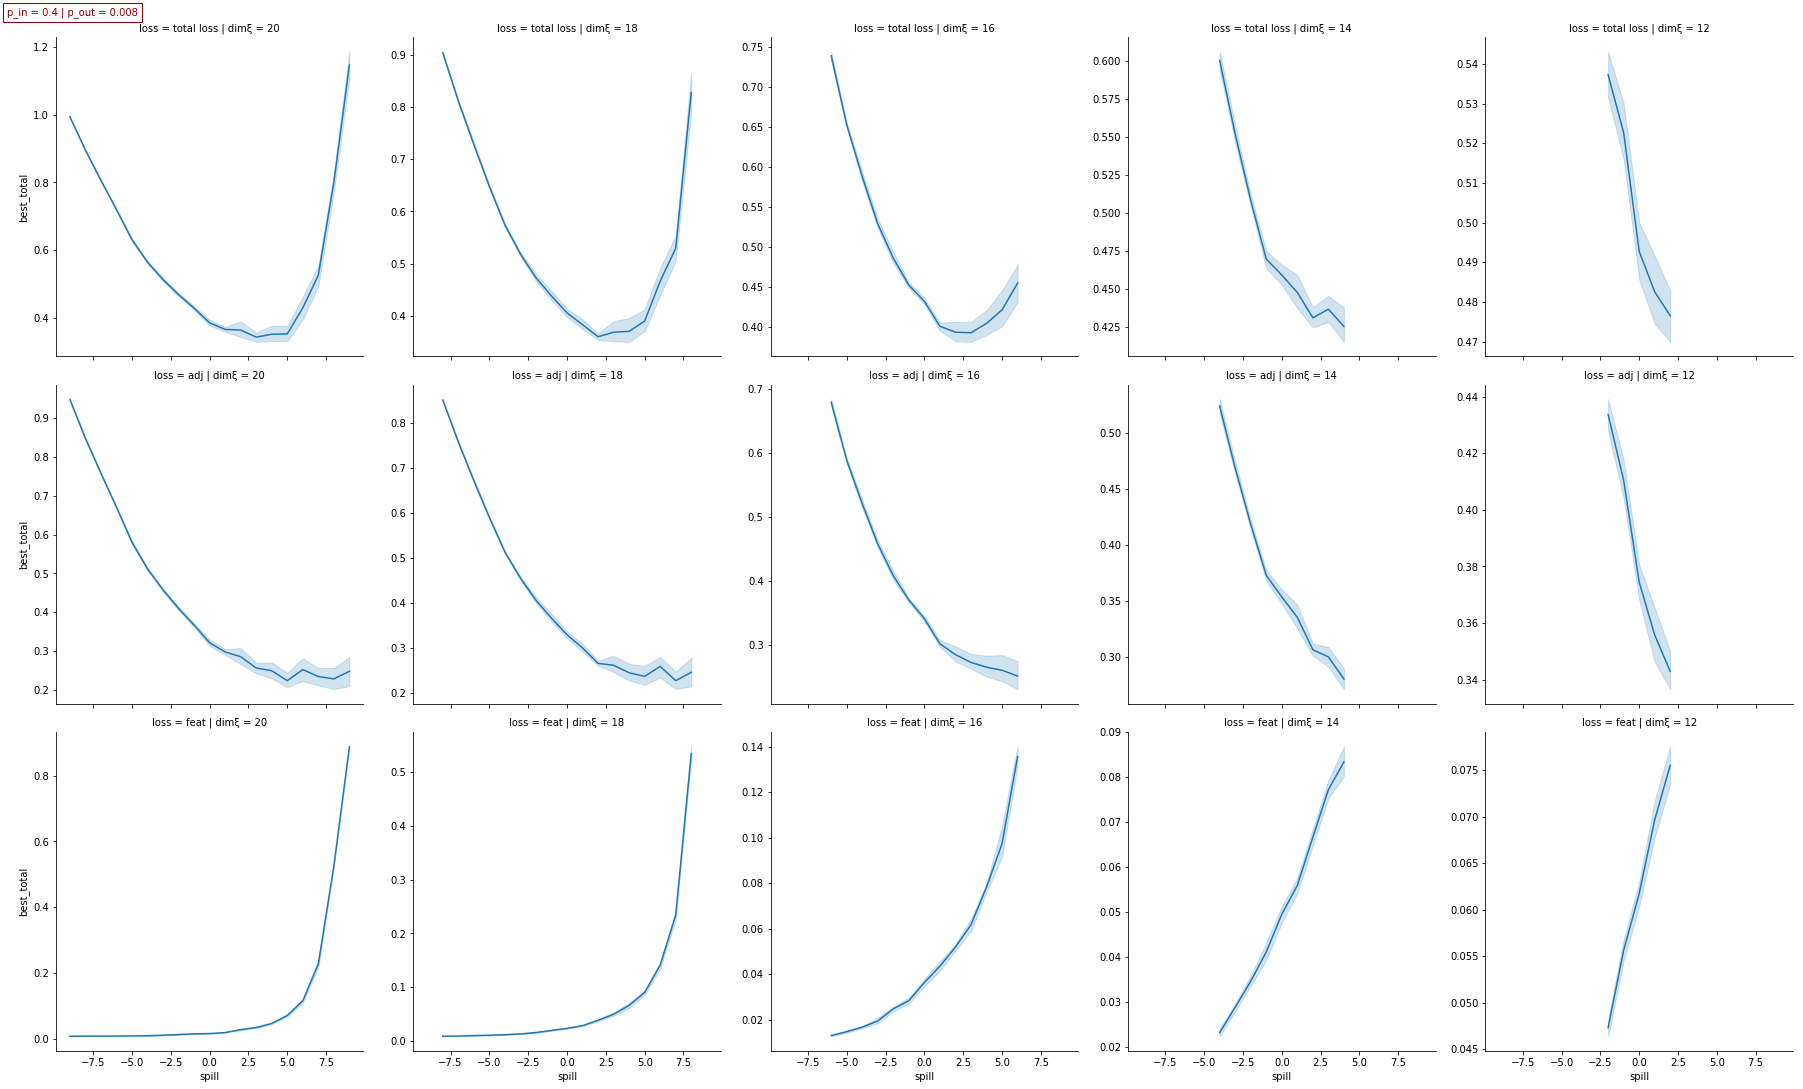

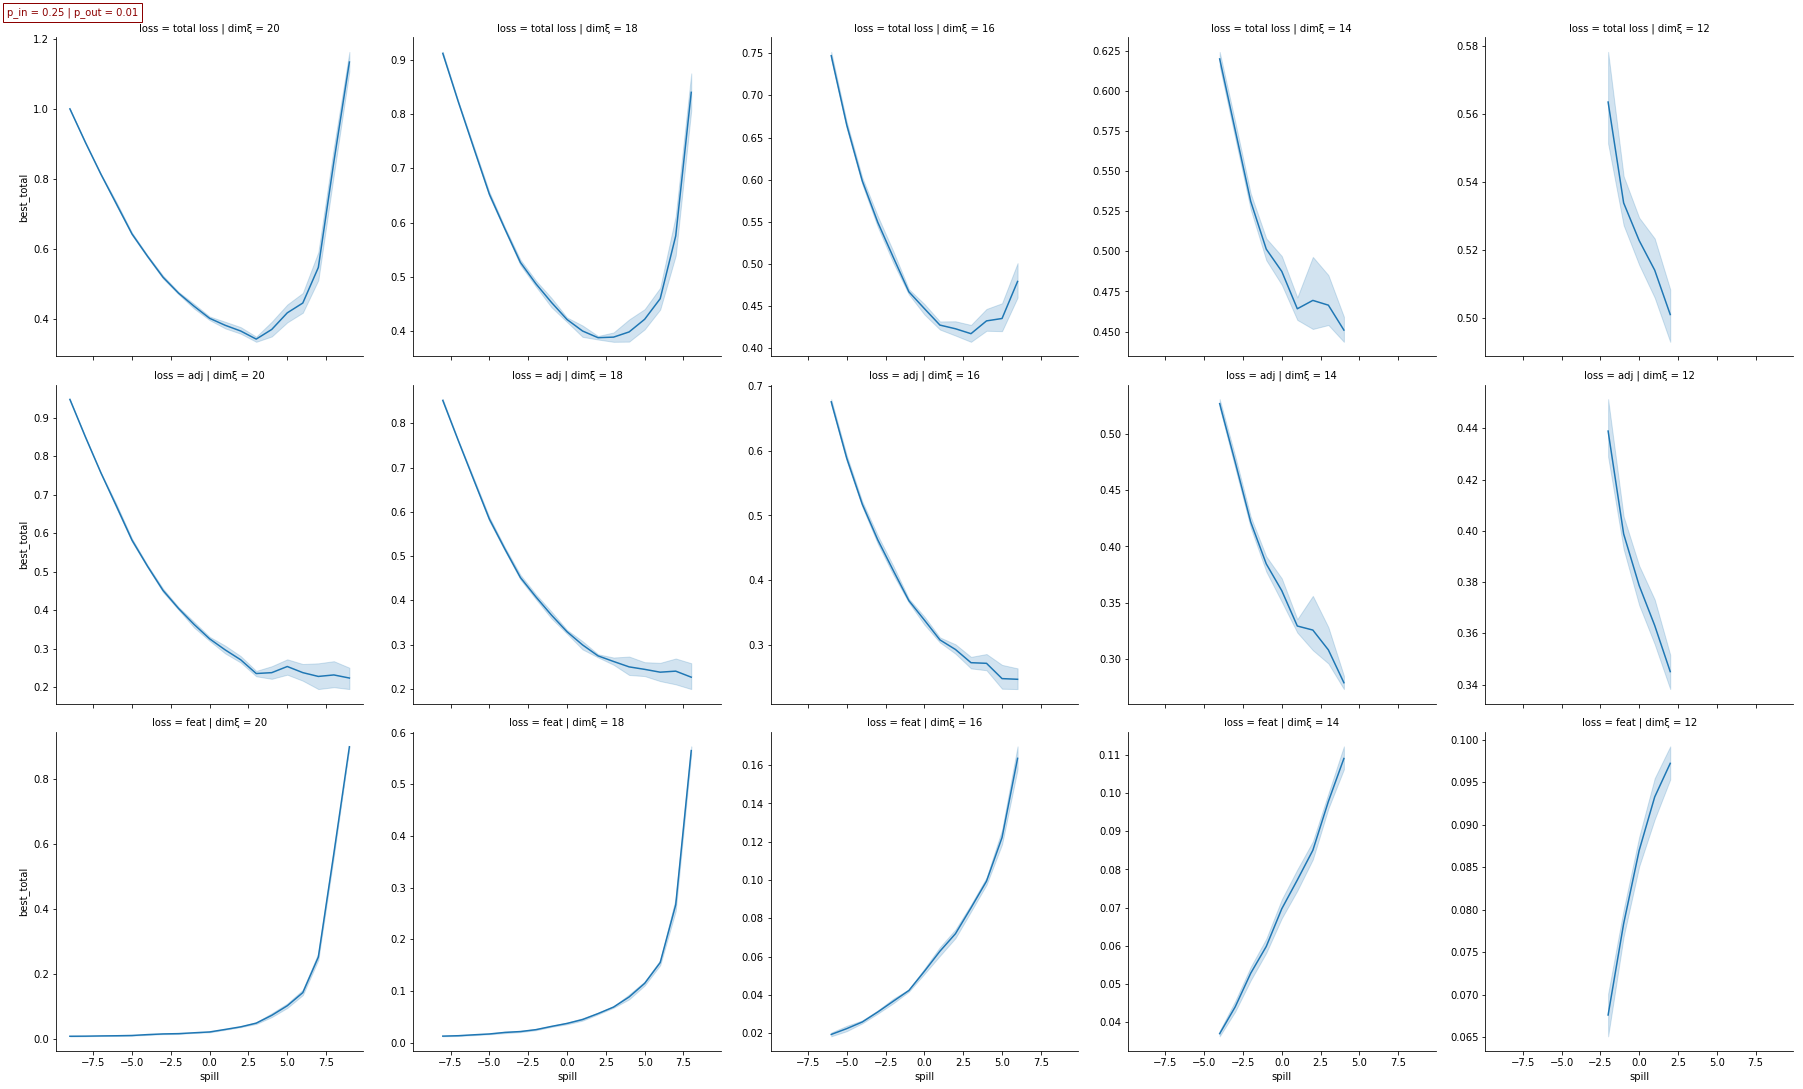

In [8]:
for p_in, p_out in zip(p_ins, p_outs):
    df = synthetic_best[synthetic_best.fsbm_p_in == p_in]
    assert len(set(df.fsbm_p_out)) == 1
    fg = sb.relplot(x='spill', y='best_total',
                    col='dimξ', col_order=range(20, 11, -2),
                    row='loss', row_order=['total loss', 'adj', 'feat'],
                    data=df[df.correlation == 1.0],
                    kind='line', legend='full', facet_kws={'sharey': False})
    fg.fig.text(0, 1, 'p_in = {} | p_out = {}'.format(p_in, p_out),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

First in absolute values

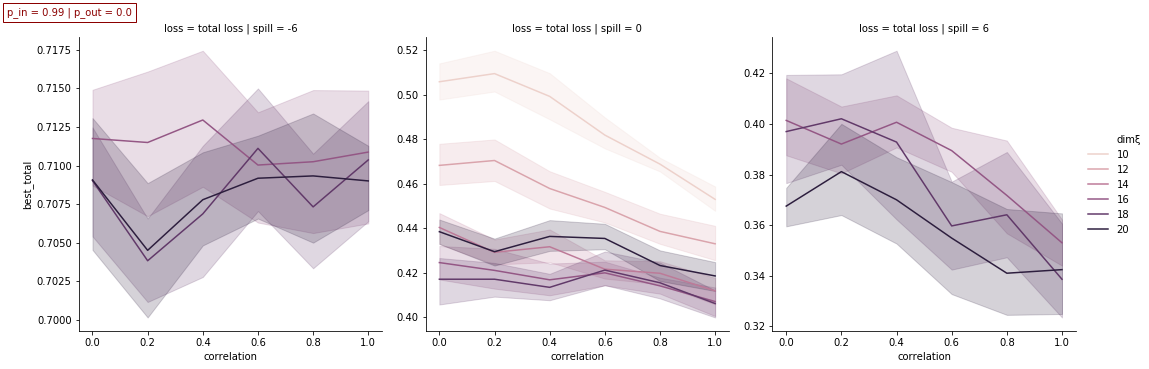

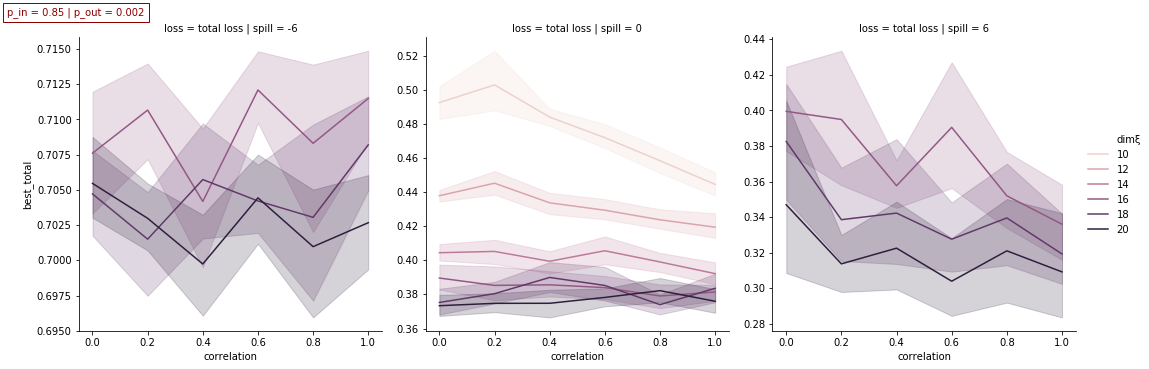

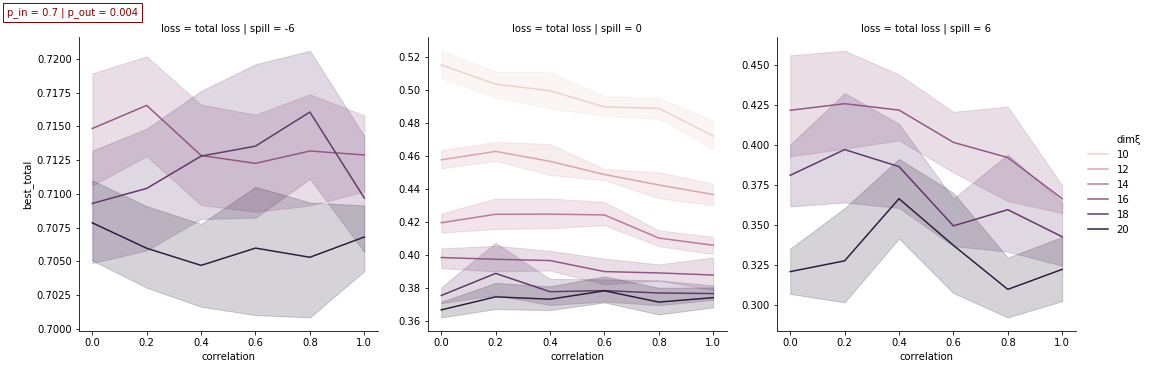

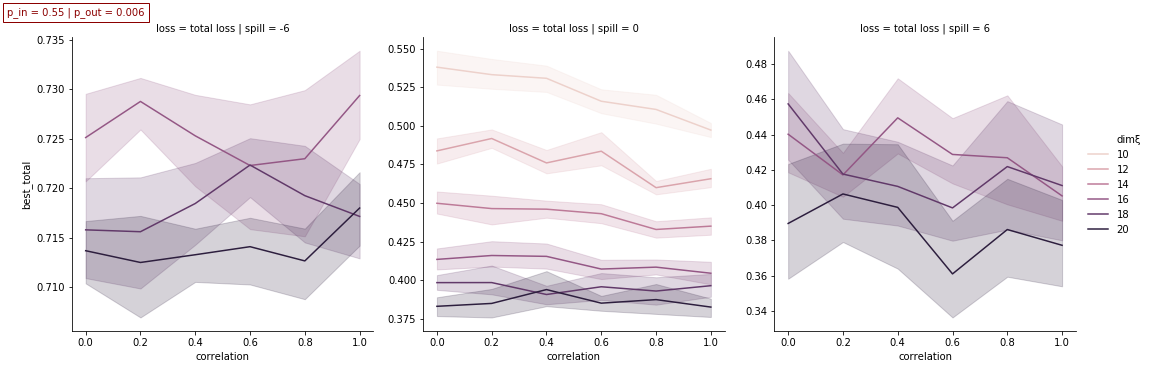

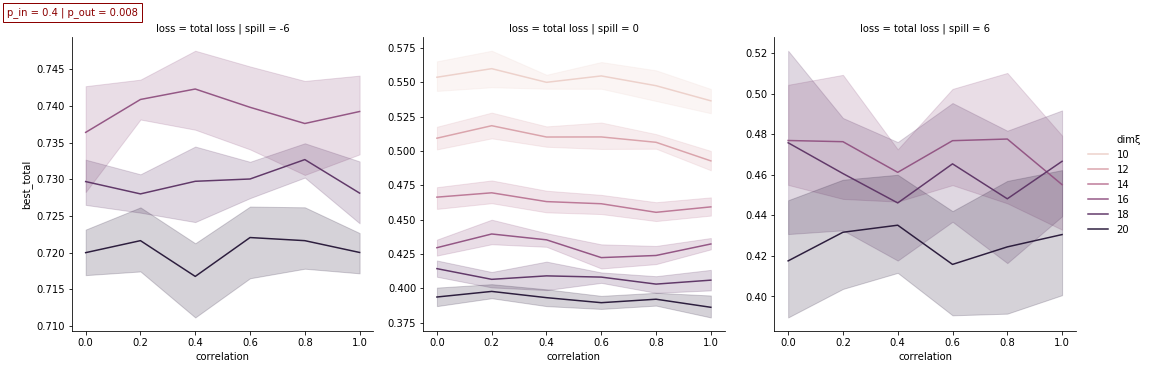

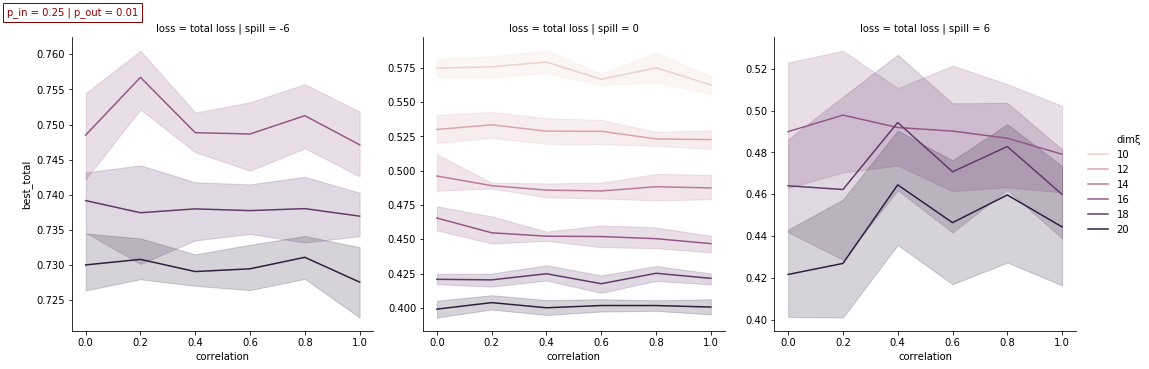

In [9]:
for p_in, p_out in zip(p_ins, p_outs):
    df = synthetic_best[synthetic_best.fsbm_p_in == p_in]
    assert len(set(df.fsbm_p_out)) == 1
    fg = sb.relplot(x='correlation', y='best_total',
                    col='spill', col_order=[-6, 0, 6],
                    hue='dimξ',
                    row='loss', row_order=['total loss'],#, 'adj', 'feat'],
                    data=df,
                    kind='line', legend='full', facet_kws={'sharey': False})
    fg.fig.text(0, 1, 'p_in = {} | p_out = {}'.format(p_in, p_out),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

Then in relative values (relative to 0 overlap)

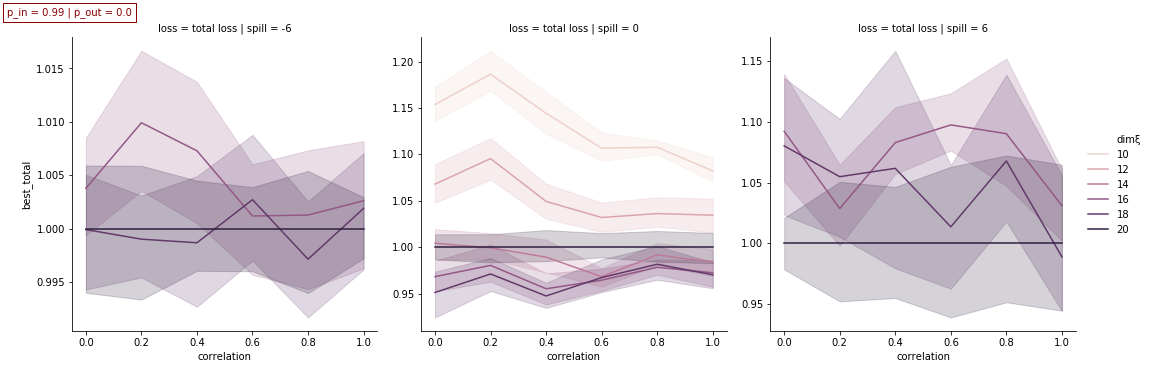

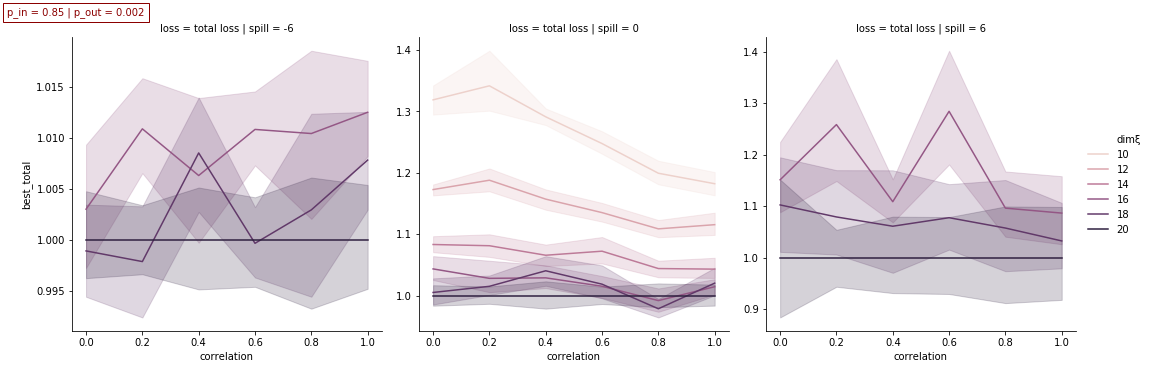

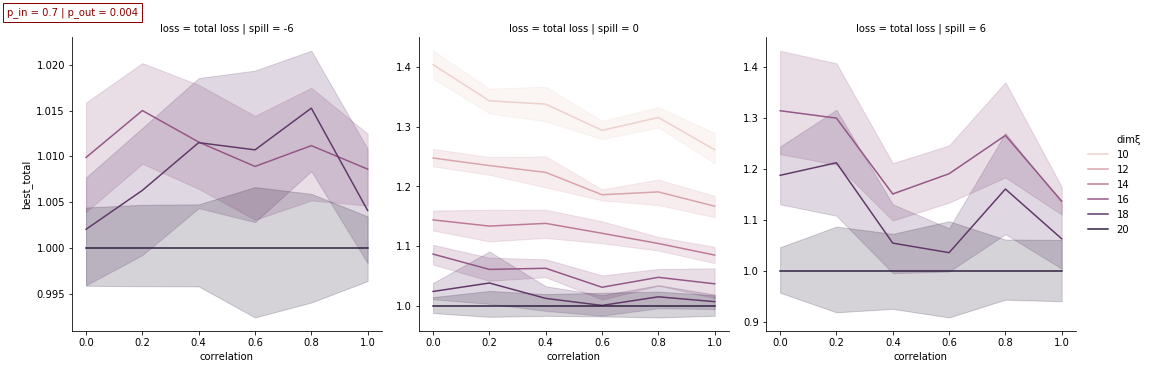

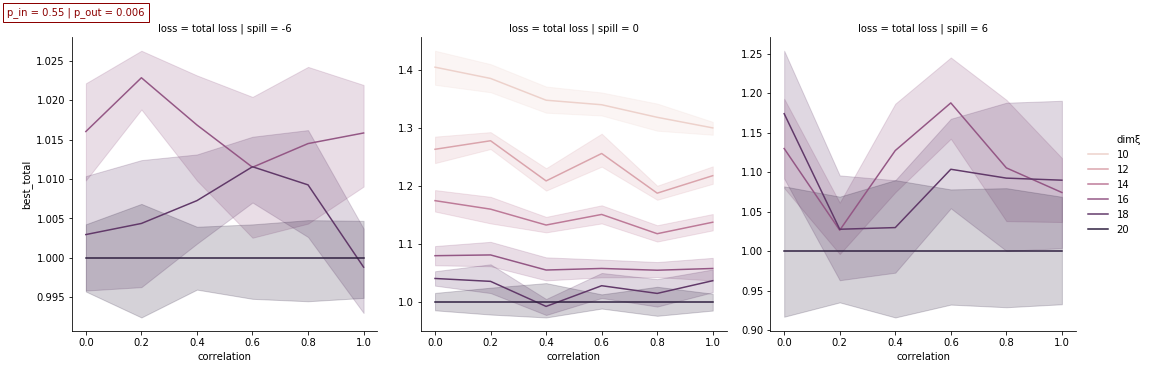

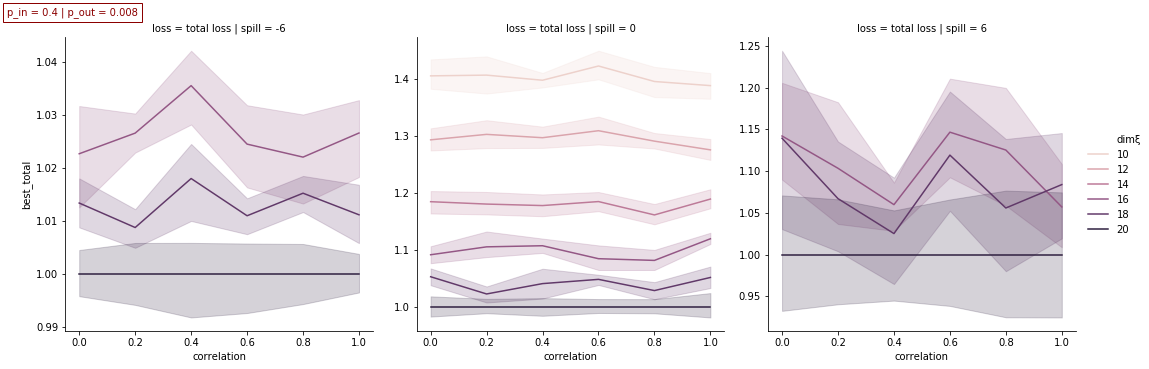

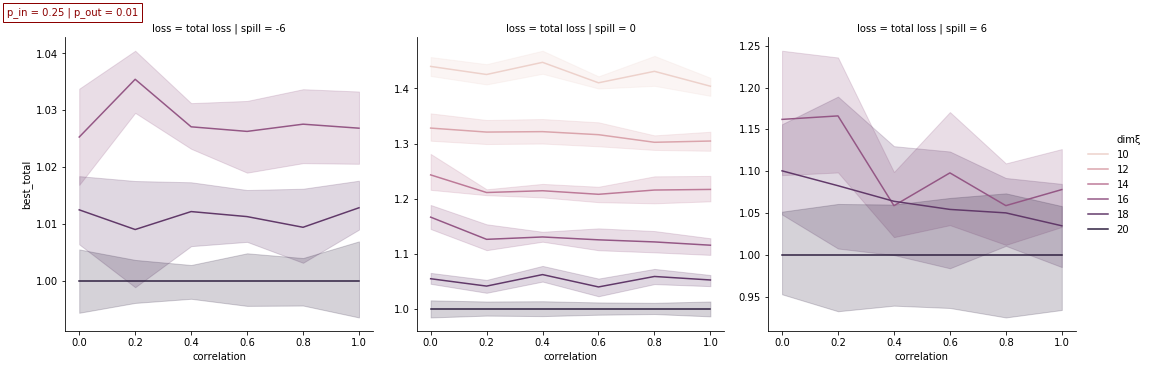

In [10]:
for p_in, p_out in zip(p_ins, p_outs):
    df = synthetic_best_relov[synthetic_best_relov.fsbm_p_in == p_in]
    assert len(set(df.fsbm_p_out)) == 1
    fg = sb.relplot(x='correlation', y='best_total',
                    col='spill', col_order=[-6, 0, 6],
                    hue='dimξ',
                    row='loss', row_order=['total loss'],
                    data=df,
                    kind='line', legend='full', facet_kws={'sharey': False})
    fg.fig.text(0, 1, 'p_in = {} | p_out = {}'.format(p_in, p_out),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

We can also 3D-plot the spill/correlation variations, for different overlap levels

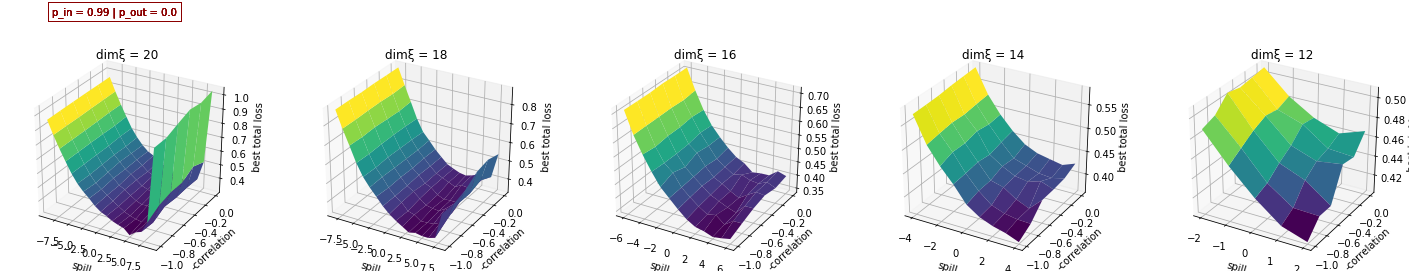

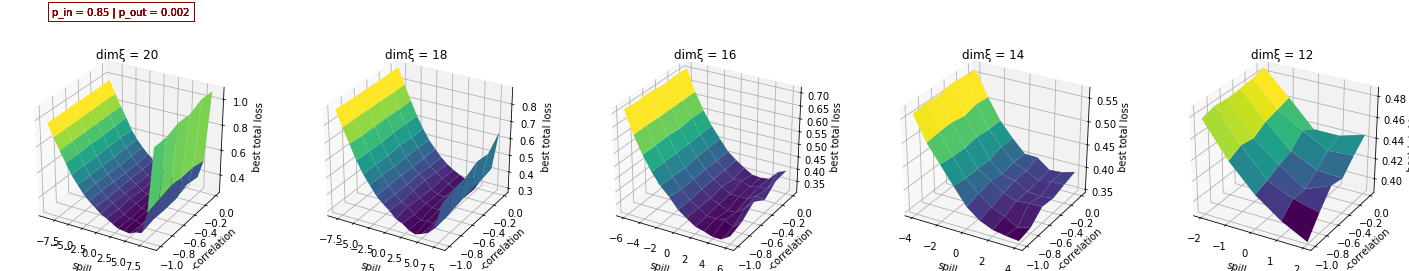

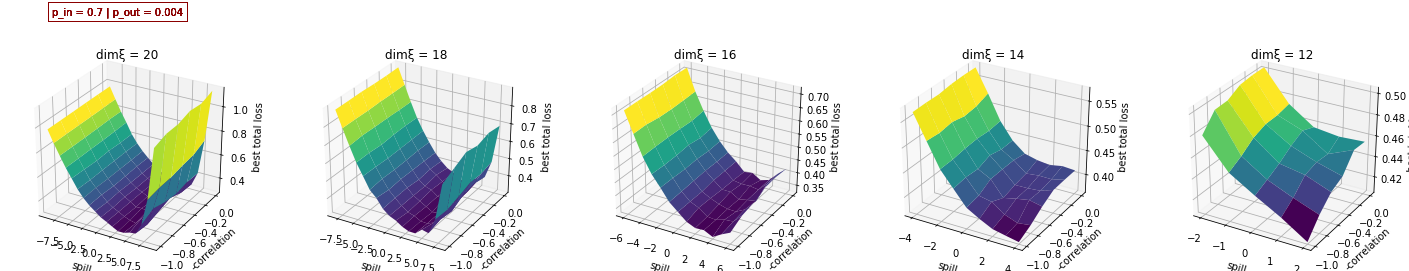

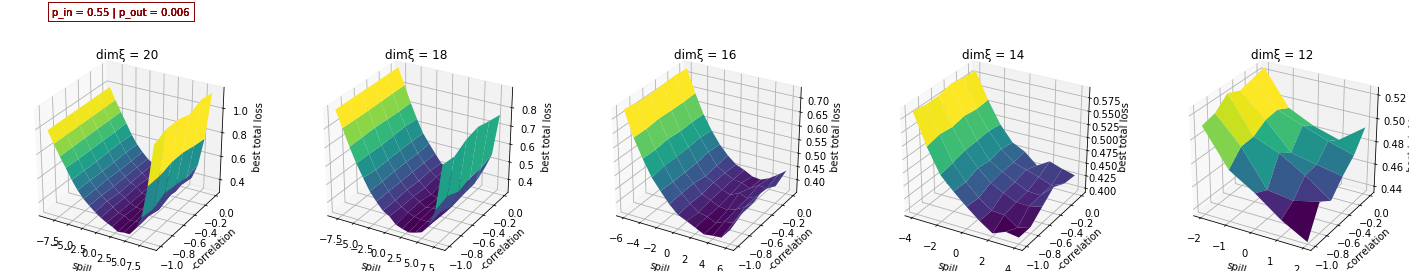

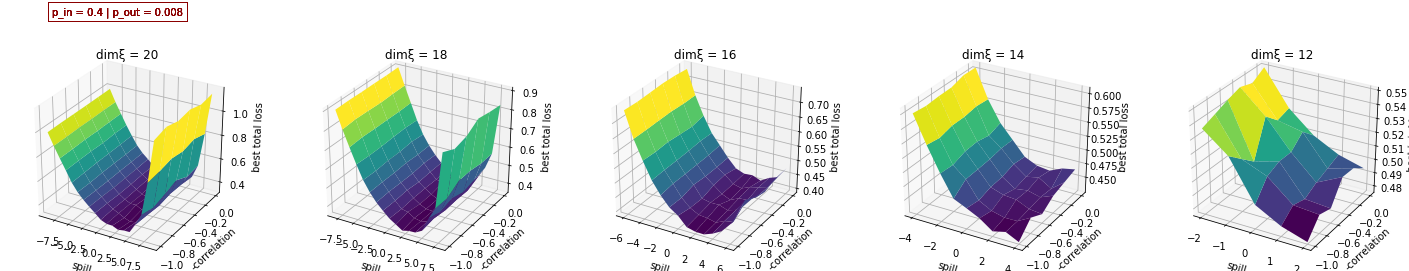

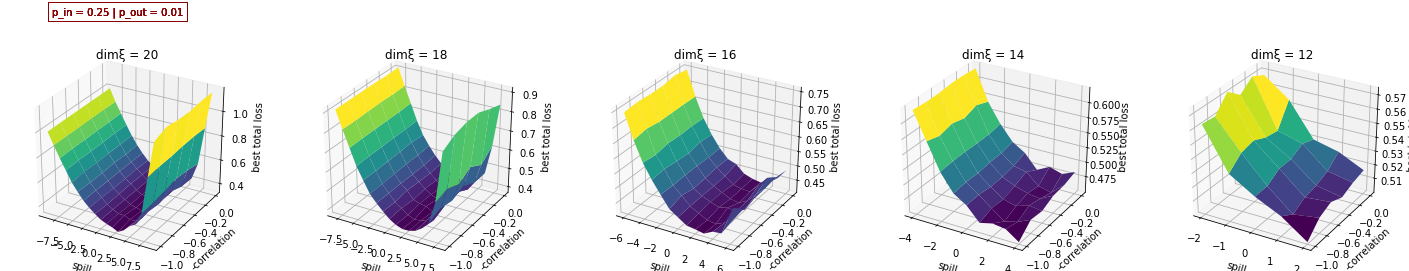

In [11]:
for p_in, p_out in zip(p_ins, p_outs):
    fig, axes = plt.subplots(1, 5, subplot_kw={'projection': '3d'}, figsize=(25, 4))
    
    for ax, dimξ in zip(axes, range(20, 11, -2)):
        df = synthetic_best[synthetic_best.fsbm_p_in == p_in]
        assert len(set(df.fsbm_p_out)) == 1
        df = df.groupby(['correlation', 'spill', 'dimξ', 'loss']).mean().reset_index()
        df = df[(df.loss == 'total loss') & (df.dimξ == dimξ)].sort_values(by=['spill', 'correlation'])
        xlen = len(np.unique(df.spill))
        ylen = len(np.unique(df.correlation))
        x = np.reshape(np.array(df.spill), (xlen, ylen))
        y = - np.reshape(np.array(df.correlation), (xlen, ylen))
        z = np.reshape(np.array(df.best_total), (xlen, ylen))

        ax.plot_surface(x, y, z, cmap='viridis')
        ax.set_xlabel('spill')
        ax.set_ylabel('-correlation')
        ax.set_zlabel('best total loss')
        ax.set_title('dimξ = {}'.format(dimξ))
        fig.text(0.15, 1, 'p_in = {} | p_out = {}'.format(p_in, p_out),
                 color='darkred', ha='left', va='center',
                 bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})